# Car Price Prediction

In this task, I used Linear Regression, Polynomial Regression, Lasso Regression and SVM to compare their (MSE) results to understand which model well-performed amongst others.

### Importing Libraries

In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.simplefilter('ignore')

### Data Preparation

#### Loading Training and Test Data

In [2]:
training_data = pd.read_csv('training_data.csv') #reading training.csv file
training_data  = training_data.dropna(subset=['price']) #part b: dropping the rows completely from training_data that has null prices

In [3]:
test_data = pd.read_csv('test_data.csv') #reading test data
test_data = test_data.dropna(subset=['price']) #dropping the rows completely from test_data that has null prices

#### Splitting Training and Test Data

In [4]:
train_x_a = training_data.drop(columns='price') #containing all input features except the price column
train_y = training_data[['price']].copy() #containing the target label "price" only

In [5]:
test_x = test_data.drop(columns='price') #containing all input features except the price column
test_y = test_data[['price']] #containing the target label "price" only

#### Handling Missing Values

In [6]:
nan_columns = training_data.columns[training_data.isna().any()].tolist() #finding the features (columns) that contain missing (NaN) values and then returning all of them in a list
train_x_b = train_x_a.fillna(train_x_a.median()) #filling the missing values with the median value of the corresponding feature

In [7]:
print(nan_columns)

['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']


In [8]:
nan_test_columns = test_data.columns[test_data.isna().any()].tolist() #finding the features (columns) that contain missing (NaN) values and then returning all of them in a list
test_x = test_x.fillna(test_x.median()) #filling the missing values with the median value of the corresponding feature

In [9]:
print(nan_test_columns)

['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']


#### Finding Categorical Columns

In [10]:
categorical_columns = train_x_b.select_dtypes(include='object').columns.tolist() #finding all features (columns) that contain categorical values ('object') and storing their column names into list categorical_columns
print(categorical_columns)

['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']


In [11]:
categorical_test_columns = test_x.select_dtypes(include='object').columns.tolist() #finding all features (columns) that contain categorical values ('object') and storing their column names into list categorical_columns 
print(categorical_test_columns)

['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']


#### Handling Categorical Columns

In [12]:
#One hot encoding function that uses pandas get_dummies.
train_x_d = pd.get_dummies(train_x_b,columns=categorical_columns) #modifying train_x_b by replacing categorical columns with their one-hot encoding representations
train_x_d.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi
0,104.3,188.8,67.2,56.2,2403.0,141.0,3.31,3.15,9.5,114.0,...,0,0,0,0,0,0,0,0,1,0
1,94.5,170.2,63.8,53.5,2024.0,97.0,3.15,3.29,9.4,69.0,...,0,0,0,0,1,0,0,0,0,0


In [13]:
test_x = pd.get_dummies(test_x,columns=categorical_test_columns) #modifying test_x by replacing categorical columns with their one-hot encoding representations
test_x.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi
0,105.8,192.7,71.4,55.7,2954.0,136.0,3.19,3.40,8.5,110.0,...,0,0,0,0,0,0,0,0,1,0
1,96.5,175.4,62.5,54.1,2372.0,110.0,3.15,3.58,9.0,86.0,...,0,0,0,1,0,0,0,0,0,0


#### Column Standardization for Training and Test Data

In [14]:
#scaling all columns in train_x_d with standardization with a transformer called StandardScaler
scaler = StandardScaler()
scaler.fit(train_x_d)
train_scaler = scaler.transform(train_x_d)
train_x_e = pd.DataFrame(data=train_scaler,index=train_x_d.index,columns=train_x_d.columns) #converting the output of scaler numpy array into dataframe after standardization also adding the original data frame’s indices and columns to the new data frame
train_x_e.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi
0,1.040486,1.218356,0.697865,1.103479,-0.217359,0.427546,-0.000506,-0.298040,-0.115772,0.312992,...,-0.080582,-0.080582,-0.114332,-0.248282,-0.720838,-0.114332,-0.315104,-0.080582,1.146051,-0.248282
1,-0.729389,-0.266100,-1.003614,-0.089818,-0.968641,-0.679464,-0.628165,0.134277,-0.142667,-0.909358,...,-0.080582,-0.080582,-0.114332,-0.248282,1.387274,-0.114332,-0.315104,-0.080582,-0.872562,-0.248282


In [15]:
train_x_e.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi
0,1.040486,1.218356,0.697865,1.103479,-0.217359,0.427546,-0.000506,-0.298040,-0.115772,0.312992,...,-0.080582,-0.080582,-0.114332,-0.248282,-0.720838,-0.114332,-0.315104,-0.080582,1.146051,-0.248282
1,-0.729389,-0.266100,-1.003614,-0.089818,-0.968641,-0.679464,-0.628165,0.134277,-0.142667,-0.909358,...,-0.080582,-0.080582,-0.114332,-0.248282,1.387274,-0.114332,-0.315104,-0.080582,-0.872562,-0.248282


In [16]:
#scaling all columns in test_x with standardization 
test_scaler = scaler.transform(test_x)
test_x = pd.DataFrame(data=test_scaler,index=test_x.index,columns=test_x.columns)
test_x.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi
0,1.311385,1.529613,2.799691,0.882498,0.874873,0.301750,-0.471250,0.473955,-0.384726,0.204338,...,-0.080582,-0.080582,-0.114332,-0.248282,-0.720838,-0.114332,-0.315104,-0.080582,1.146051,-0.248282
1,-0.368190,0.148909,-1.654180,0.175359,-0.278810,-0.352393,-0.628165,1.029791,-0.250249,-0.447582,...,-0.080582,-0.080582,-0.114332,4.027682,-0.720838,-0.114332,-0.315104,-0.080582,-0.872562,-0.248282


### Data Exploration

#### Understanding Distribution of Variables

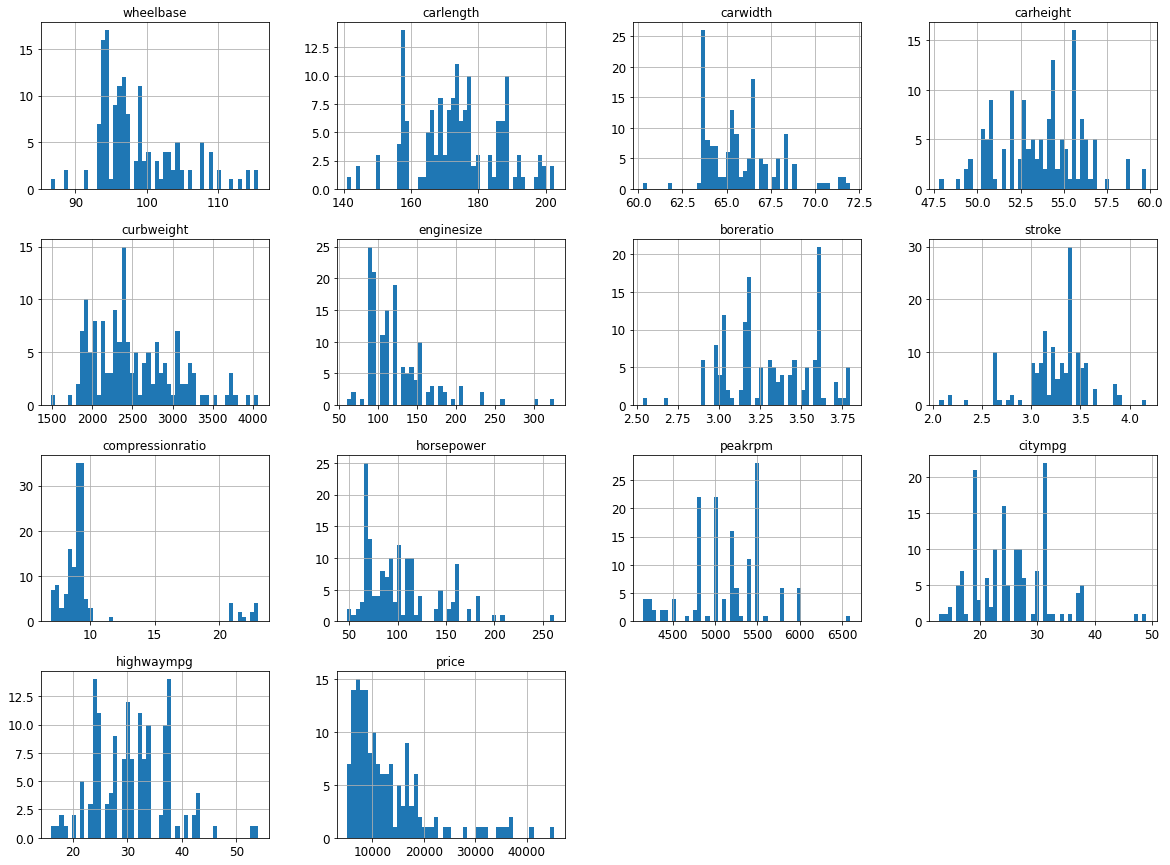

In [17]:
training_data.hist(bins=50, figsize=(20,15)) 
plt.show() 
#plotting the histogram of each of the variables in your dataset to understand how each variable is distributed
#For example, horsepower and peakrpm are clear distributions to see the extreme points, in both distributions the outliers are on te right tail,for the value close to 260 is extreme since generally majority of data is below 230,and for peakrpm there is a value close to 6600 which is extreme since the majority of data is below 6100. These are not only the ones that has extreme points also citympg,boreratio,highwaympg etc has

#### Understanding the correlation between variables

In [18]:
#calculating the correlation score between all continuous variables in training_data and the target.
corr_matrix = training_data.corr().abs()
correlations  = corr_matrix['price'].sort_values(ascending=False)
top_5_corr = correlations.index[1:6].tolist() #taking top 5 absolute correlations
correlations

price               1.000000
enginesize          0.873498
curbweight          0.843303
carwidth            0.812180
horsepower          0.801589
carlength           0.710782
highwaympg          0.705712
wheelbase           0.692405
citympg             0.678330
boreratio           0.487909
carheight           0.211048
peakrpm             0.160609
compressionratio    0.097012
stroke              0.064351
Name: price, dtype: float64

In [19]:
print(top_5_corr)

['enginesize', 'curbweight', 'carwidth', 'horsepower', 'carlength']


array([[<AxesSubplot:xlabel='enginesize', ylabel='enginesize'>,
        <AxesSubplot:xlabel='curbweight', ylabel='enginesize'>,
        <AxesSubplot:xlabel='carwidth', ylabel='enginesize'>,
        <AxesSubplot:xlabel='horsepower', ylabel='enginesize'>,
        <AxesSubplot:xlabel='carlength', ylabel='enginesize'>],
       [<AxesSubplot:xlabel='enginesize', ylabel='curbweight'>,
        <AxesSubplot:xlabel='curbweight', ylabel='curbweight'>,
        <AxesSubplot:xlabel='carwidth', ylabel='curbweight'>,
        <AxesSubplot:xlabel='horsepower', ylabel='curbweight'>,
        <AxesSubplot:xlabel='carlength', ylabel='curbweight'>],
       [<AxesSubplot:xlabel='enginesize', ylabel='carwidth'>,
        <AxesSubplot:xlabel='curbweight', ylabel='carwidth'>,
        <AxesSubplot:xlabel='carwidth', ylabel='carwidth'>,
        <AxesSubplot:xlabel='horsepower', ylabel='carwidth'>,
        <AxesSubplot:xlabel='carlength', ylabel='carwidth'>],
       [<AxesSubplot:xlabel='enginesize', ylabel='horsep

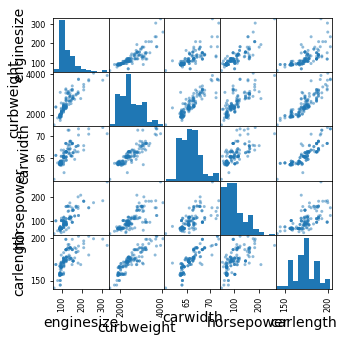

In [20]:
scatter_matrix(training_data[top_5_corr], figsize=(5, 5)) #plotting each of the 5 variables which are the top_5_corr

### Using Linear Regression to Predict the Car Prices

#### Creating the Model and Training

In [21]:
lr_model = LinearRegression() #a linear regression model is created
lr_model.fit(train_x_e,train_y) #training the model with train_x_e and train_y

LinearRegression()

#### Making Predictions on Training Data

In [22]:
predictions = lr_model.predict(train_x_e) #getting predictions

In [23]:
train_mse_score = mean_squared_error(train_y, predictions) #getting MSE for training data
print(train_mse_score)

4293452.590313228


#### Applying 5-Fold Cross Validation on Training Data

In [24]:
scores = cross_val_score(lr_model,train_x_e,train_y,scoring = "neg_mean_squared_error", cv=5) #performing 5-fold cross validation with training data
scores = -(scores) #To obtain MSE, we get the absolute value.
scores #printing MSE score for each fold

array([10057504.28226569,  6941861.46536291,  8010686.21848618,
       11491802.34766714,  6098813.96464961])

In [25]:
average_mse = scores.mean() #average mse 
print(average_mse)

8520133.655686306


#### Making predictions on Test Data

In [26]:
predicted_values = lr_model.predict(test_x) #predicting the prices of cars in test_x data using LR model that I created in part (i) 

In [27]:
print(predicted_values[10:13])

[[25820.17373261]
 [15266.75224294]
 [ 7061.79177366]]


In [28]:
test_mse_score = mean_squared_error(test_y, predicted_values)
print(test_mse_score) #test set MSE

15145368.208050132


In [29]:
print(lr_model.coef_) #model’s coefficients

[[ -182.50390789    17.77791293   482.81638969   104.58617988
   1594.18156825  4256.71313249   -38.99302906 -1321.89317472
    384.75573887  1307.10308185   517.30038623  -656.6777968
    909.82948041    63.44882098   -63.44882098  -345.01712899
    345.01712899   -79.19764443    79.19764443   309.15477368
     41.94235625  -351.57058775   212.54573996    26.44248644
   -100.41702336   -55.47707253   101.51605056  -267.79355313
    267.79355313  -371.41920837  -187.39716713  1176.64256697
    -84.87719409 -1725.97024765   176.79676558  1597.61307444
   -137.55006193  -995.94531305   567.19331492   431.12406866
   -315.88166818   176.79676558   130.33179437   -60.94295514
    176.79676558    63.44882098  -119.02206221   183.04212938
   -516.78989561]]


In [30]:
predicted = []
predicted_values.tolist()[0]
for i in predicted_values.tolist():
    predicted.append(i[0])
df = pd.DataFrame({'Actual': test_y['price'].to_list(), 'Predicted': predicted})
df.head()

,Actual,Predicted
0,18920.0,18557.603856
1,10295.0,8854.693601
2,28176.0,26904.265634
3,35550.0,30994.967566
4,34028.0,36750.881719


### Using Polynomial Regression to Predict the Car Prices

In [31]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
#running a polynomial transformation with degree 2 on train_x_e
train_x_m = pd.DataFrame(poly_features.fit_transform(train_x_e))

In [32]:
train_x_m.head(2)

,0,1,2,3,4,5,6,7,8,9,...,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273
0,1.040486,1.218356,0.697865,1.103479,-0.217359,0.427546,-0.000506,-0.298040,-0.115772,0.312992,...,0.099291,0.025392,-0.361126,0.078235,0.006494,-0.092351,0.020007,1.313433,-0.284544,0.061644
1,-0.729389,-0.266100,-1.003614,-0.089818,-0.968641,-0.679464,-0.628165,0.134277,-0.142667,-0.909358,...,0.099291,0.025392,0.274948,0.078235,0.006494,0.070313,0.020007,0.761364,0.216641,0.061644


In [33]:
lr_model_poly  = LinearRegression() #creating LR for polynomial
lr_model_poly.fit(train_x_m, train_y)

LinearRegression()

In [34]:
polynomial_feature_scores = -(cross_val_score(lr_model_poly, train_x_m, train_y, scoring = "neg_mean_squared_error", cv=5)) #5-fold cross validation using train_x_m and train_y
polynomial_feature_scores

array([2.25674495e+07, 2.92732556e+26, 3.78662350e+30, 3.04495790e+23,
       8.35567426e+28])

In [35]:
average_mse = polynomial_feature_scores.mean() #MSE of polynomial scores
print(average_mse)

7.740946559776287e+29


### Using Lasso Regression to Predict the Car Prices

In [36]:
lasso = Lasso() #created lasso regression
lasso.fit(train_x_m,train_y)

Lasso()

In [37]:
CrossVAl_Lasso = -(cross_val_score(lasso, train_x_m, train_y, scoring = "neg_mean_squared_error", cv=5))
average_mse = CrossVAl_Lasso.mean() #lasso mean result
print(average_mse)

36528621.24537846


#### Calculating and storing all 5-fold CV MSE scores for alpha values between 1 and 3000 with a step size of 10 in the following loop

In [38]:
all_scores = []
all_alphas = []
for i in range(1, 3000, 10): #in each iteration the alpha is setted to a different number the aim is to find to  optimum alpha which gives us the lowest error
    regLasso = Lasso(alpha = i) #created Lasso regression model wit alpha=i
    cross_lasso = cross_val_score(regLasso, train_x_m, train_y,scoring="neg_mean_squared_error", cv=5) #5-fold CV MSE scores 
    cross_lasso = -(cross_lasso) #taking absolute
    scores_mean = cross_lasso.mean() #taking mean of mse scores
    all_alphas.append(i) #all_alphas
    all_scores.append(scores_mean) 

minerror = min(all_scores)
m_i = all_scores.index(minerror)
mini_alpha = all_alphas[m_i]

min_error = min(all_scores)
min_index = all_scores.index(min_error)
min_alpha = all_alphas[min_index]
print(all_scores)

[36528621.24537846, 11307771.590894517, 11110976.420398623, 11588897.233806293, 12051970.702692311, 12388076.799739141, 11982234.680053392, 11720009.499411317, 11709891.939258104, 11919856.415190563, 11869743.79702182, 11787607.540306624, 11650066.575539846, 11507004.254307058, 11279757.878626851, 10917653.440356344, 10577784.838279994, 10311837.225586085, 10158428.873887572, 9994548.453799043, 9914937.305241857, 9843656.170003068, 9788981.153852222, 9763659.890244892, 9735216.695349578, 9718791.884552445, 9704091.885806525, 9764437.509938303, 9866185.245833578, 9950278.7355058, 10018971.683013106, 10043338.46662253, 10076987.877078762, 10067878.211191924, 10056678.967408648, 10045502.768664297, 10031765.87036168, 10025464.093035888, 10015246.137989331, 10004050.21335527, 9988334.506706143, 9977538.570726324, 9974835.969121626, 9987881.31860807, 10003243.816564005, 10019701.984897677, 10033601.761054805, 10044829.355244834, 10061754.73314549, 10085786.954439875, 10135769.2951068, 10189

#### Plotting alphas vs error scores in order to see the optimal alpha and its respective error

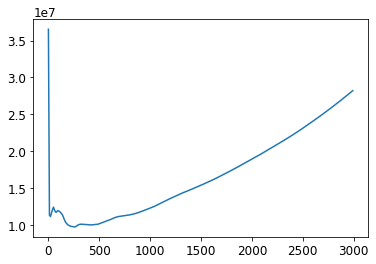

In [39]:
plt.plot(all_alphas, all_scores)
plt.show()

In [40]:
print(f"Minimum error was {round(min_error, 2)} at alpha {min_alpha}")

Minimum error was 9704091.89 at alpha 261


### Using SVM to Predict the Car Prices

Creating a support vector regression since Linear regression was not good enough and decided to use SVMs in the grid_param the search parameters are included.

In [41]:
reg_SVM = SVR()
grid_param = [
    {'kernel' : ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]},
    {'kernel' : ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0], 'gamma':[0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
  ]
#grid search to find the best set of parameters to use
grid_search = GridSearchCV(reg_SVM, grid_param, cv=5,scoring='neg_mean_squared_error', return_train_score=True) #search part
grid_search.fit(train_x_e, train_y) #best model parameters found, we fit and transform our train and target datasets

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0,
                                3000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [42]:
best_mse = -(grid_search.best_score_) #best grid score we get
best_parameters = grid_search.best_params_ #best grid parameters

In [43]:
best_mse

9849741.28153356

In [44]:
best_parameters

{'C': 3000.0, 'kernel': 'linear'}